In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

英文到法语，有个数据文件，是英语到法语语名对fra.txt，会有一名英语到两句不同的表达的法语的情况

In [2]:
print(tf.__version__)

2.0.0


In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
import numpy as np

batch_size = 64  # Batch size for training.
epochs = 50  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = 'fra.txt'


In [4]:
#将输入向量化
input_texts=[]
target_texts=[]
input_characters=set()
target_characters=set()
with open(data_path,'r',encoding='utf-8') as f:
    lines = f.read().split('\n')


In [5]:
lines[:10]

['Go.\tVa !\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1158250 (Wittydev)',
 'Hi.\tSalut !\tCC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #509819 (Aiji)',
 'Hi.\tSalut.\tCC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #4320462 (gillux)',
 'Run!\tCours\u202f!\tCC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #906331 (sacredceltic)',
 'Run!\tCourez\u202f!\tCC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #906332 (sacredceltic)',
 'Who?\tQui ?\tCC-BY 2.0 (France) Attribution: tatoeba.org #2083030 (CK) & #4366796 (gillux)',
 'Wow!\tÇa alors\u202f!\tCC-BY 2.0 (France) Attribution: tatoeba.org #52027 (Zifre) & #374631 (zmoo)',
 'Fire!\tAu feu !\tCC-BY 2.0 (France) Attribution: tatoeba.org #1829639 (Spamster) & #4627939 (sacredceltic)',
 "Help!\tÀ l'aide\u202f!\tCC-BY 2.0 (France) Attribution: tatoeba.org #435084 (lukaszpp) & #128430 (sysko)",
 'Jump.\tSaute.\tCC-BY 2.0 (France) Attribution: tatoeba.org #631038 (Shishi

In [6]:
a,b=lines[0].split('\t')[:2]
print(a,b)

Go. Va !


英文句子的所有字符，法文句子的所有组成字符

In [7]:
for line in lines[:min(num_samples,len(lines)-1)]:
    input_text,target_text=line.split('\t')[:2]
    #\t作为句子的开始，\n作为句子的结束
    target_text='\t'+target_text+'\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)
    

input_characters = sorted(list(input_characters))
target_characters=sorted(list(target_characters))

获取英文句子的最长的长度，法文句子的最长长度，以及英文所有句子所用字符的个数和法文所有句子所用字符的个数

In [8]:
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length =max([len(txt) for txt in input_texts])
max_decoder_seq_length =max([len(txt) for txt in target_texts])

print("number of samples:",len(input_texts))
print("number of unique input tokens:",num_encoder_tokens)
print("number of unique output tokens:",num_decoder_tokens)
print("max sequence length for inputs:",max_encoder_seq_length)
print("max sequence length for outputs:",max_decoder_seq_length)

number of samples: 10000
number of unique input tokens: 70
number of unique output tokens: 93
max sequence length for inputs: 16
max sequence length for outputs: 59


将所有的英文字符和法文字符编码成字典，形成字符与其数字表示对

In [9]:
input_token_index=dict([(char,i) for i,char in enumerate(input_characters)])
target_token_index=dict([(char,i) for i,char in enumerate(target_characters)])

对英文和法文分别用one-hot方式编码，只有编码成数字，才可以用于计算机来操作

In [10]:
encoder_input_data=np.zeros((len(input_texts),max_encoder_seq_length,num_encoder_tokens),dtype=np.float32)
decoder_input_data=np.zeros((len(input_texts),max_decoder_seq_length,num_decoder_tokens),dtype=np.float32)
decoder_target_data=np.zeros((len(input_texts),max_decoder_seq_length,num_decoder_tokens),dtype=np.float32)




In [11]:
for i,(input_text,target_text) in enumerate(zip(input_texts,target_texts)):
    for t,char in enumerate(input_text):
        encoder_input_data[i,t,input_token_index[char]]=1.
    encoder_input_data[i,t+1:,input_token_index[' ']] = 1. #有字符部分之后可以用空格表示
    for t ,char in enumerate(target_text):
        decoder_input_data[i,t,target_token_index[char]]=1.
        #目标文本decoder_target_data要比decoder_input_data早一个时间步，并且不包括开始步
        if t>0:
            decoder_target_data[i,t-1,target_token_index[char]]=1.
    decoder_input_data[i,t+1:,target_token_index[' ']]=1.
    decoder_target_data[i,t:,target_token_index[' ']] =1.
    

准备定义模型

In [12]:
tf.keras.backend.clear_session()
#编写encoder
encoder_inputs = Input(shape=(None,num_encoder_tokens))
encoder = LSTM(latent_dim,return_state=True)
encoder_outputs,state_h,state_c =encoder(encoder_inputs)
encoder_states=[state_h,state_c] #获取取后的状态
#编写decoder
decoder_inputs = Input(shape=(None,num_decoder_tokens))
decoder_lstm = LSTM(latent_dim,return_sequences=True,return_state=True)
decoder_outputs,_,_ =decoder_lstm(decoder_inputs,initial_state=encoder_states)
decoder_dense=Dense(num_decoder_tokens,activation='softmax')
decoder_outputs=decoder_dense(decoder_outputs)

model=Model(inputs=[encoder_inputs,decoder_inputs],outputs=[decoder_outputs])



In [13]:
#编译并训练模型
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
metrics=['accuracy']
model.compile(optimizer=optimizer,loss=loss,metrics=metrics)


In [14]:
history=model.fit([encoder_input_data,decoder_input_data],decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)

Train on 8000 samples, validate on 2000 samples
Epoch 1/50
8000/8000 [==============================] - 10s 1ms/sample - loss: 1.3355 - accuracy: 0.7188 - val_loss: 1.1313 - val_accuracy: 0.6959
Epoch 2/50
8000/8000 [==============================] - 6s 773us/sample - loss: 0.8938 - accuracy: 0.7525 - val_loss: 0.9395 - val_accuracy: 0.7456
Epoch 3/50
8000/8000 [==============================] - 6s 771us/sample - loss: 0.7597 - accuracy: 0.7935 - val_loss: 0.8035 - val_accuracy: 0.7750
Epoch 4/50
8000/8000 [==============================] - 6s 775us/sample - loss: 0.6574 - accuracy: 0.8146 - val_loss: 0.7180 - val_accuracy: 0.7954
Epoch 5/50
8000/8000 [==============================] - 6s 773us/sample - loss: 0.5982 - accuracy: 0.8286 - val_loss: 0.6747 - val_accuracy: 0.8052
Epoch 6/50
8000/8000 [==============================] - 6s 775us/sample - loss: 0.5619 - accuracy: 0.8374 - val_loss: 0.6358 - val_accuracy: 0.8158
Epoch 7/50
8000/8000 [==============================] - 6s 773us/

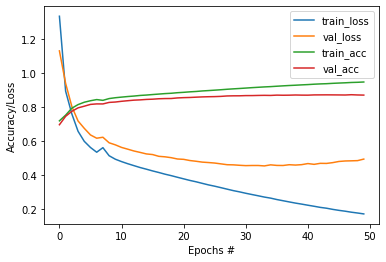

In [15]:
N = np.arange(len(history.history['loss']))
plt.figure()
plt.plot(N,history.history['loss'],label='train_loss')
plt.plot(N,history.history['val_loss'],label='val_loss')
plt.plot(N,history.history['accuracy'],label='train_acc')
plt.plot(N,history.history['val_accuracy'],label='val_acc')
plt.grid(False)
plt.xlabel('Epochs #')
plt.ylabel('Accuracy/Loss')
plt.legend()

In [16]:
#训练好后保存模型
model.save('model_s2s.hdf5',save_format='h5')


进行推理环节，思路如下：
1. 使用encoder将输入英文编码，获得decoder的初始状态
2. 基于获得的初始状态，和序列起始‘\t',decoder只运行一个step,获得输出和状态，这个输出将是下一步的输入
3. 重复步骤2

In [17]:
#使用模型的一部分
encoder_model = Model(encoder_inputs,encoder_states)

decoder_state_input_h=Input(shape=(latent_dim,))
decoder_state_input_c=Input(shape=(latent_dim,))
decoder_states_inputs=[decoder_state_input_h,decoder_state_input_c]
decoder_outputs,state_h,state_c=decoder_lstm(decoder_inputs,initial_state=decoder_states_inputs)
decoder_states = [state_h,state_c]
decoder_outputs=decoder_dense(decoder_outputs)
decoder_model =Model([decoder_inputs]+decoder_states_inputs,[decoder_outputs]+decoder_states)

将数字反转成字母，这样就会比较好读

In [18]:
reverse_input_char_index = dict([(i,char) for char,i in input_token_index.items()])
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

In [25]:
def decode_sequence(input_seq):
    #使用encoder获取初始状态
    states_value = encoder_model.predict(input_seq)    
    #产生一个空的目标序列，因为只执行一步，所以l输入只有一个，输出也只有一个结果
    target_seq = np.zeros((1,1,num_decoder_tokens))
    #用起始字符填充目标序列的第一个位置
    target_seq[0,0,target_token_index['\t']]=1.
    #对batch size的数据进行循环就可以，这里为了简单，使用batch size=1
    stop_condition=False
    decoded_sentence=''
    
    while not stop_condition:
        output_tokens,h,c = decoder_model([target_seq]+states_value)
        #获取输出结果
        sampled_token_index = np.argmax(output_tokens[0,-1,:])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char
        #退出条件，达到最大长度，或是到达句子终点
        if (sampled_char=='\n' or len(decoded_sentence)>max_decoder_seq_length):
            stop_condition=True
        #更新下一步要用的目标序列
        target_seq=np.zeros((1,1,num_decoder_tokens))
        target_seq[0,0,sampled_token_index]=1.
        #更新下一步要用的state
        states_value=[h,c]
    return decoded_sentence
    
    

In [32]:
for seq_index in range(9900,10000):
    #从训练集中获取一部分数据来预测
    input_seq = encoder_input_data[seq_index:seq_index+1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:',input_texts[seq_index])
    print('Decoded sentence:',decoded_sentence.strip())
    print('True sentence:',target_texts[seq_index])

-
Input sentence: Check these out.
Decoded sentence: Vérifiez ça.
True sentence: 	Regardez ceux-ci !

-
Input sentence: Clean your room.
Decoded sentence: Prrêtes vous bancer ?
True sentence: 	Nettoyez votre chambre.

-
Input sentence: Clean your room.
Decoded sentence: Prrêtes vous bancer ?
True sentence: 	Nettoie ta chambre.

-
Input sentence: Clean your room.
Decoded sentence: Prrêtes vous bancer ?
True sentence: 	Nettoie ta chambre !

-
Input sentence: Clean your room.
Decoded sentence: Prrêtes vous bancer ?
True sentence: 	Nettoyez votre chambre !

-
Input sentence: Close that door.
Decoded sentence: Fermez la porte !
True sentence: 	Ferme cette porte !

-
Input sentence: Close that door.
Decoded sentence: Fermez la porte !
True sentence: 	Fermez cette porte !

-
Input sentence: Close the hatch.
Decoded sentence: Ferme la porte !
True sentence: 	Fermez la trappe.

-
Input sentence: Close the hatch.
Decoded sentence: Ferme la porte !
True sentence: 	Ferme la trappe.

-
Input senten

-
Input sentence: Did you take it?
Decoded sentence: L'avez-vous vue ?
True sentence: 	L'as-tu pris ?

-
Input sentence: Did you take it?
Decoded sentence: L'avez-vous vue ?
True sentence: 	L'avez-vous pris ?

-
Input sentence: Dig a deep hole.
Decoded sentence: Dites surtimentent.
True sentence: 	Creuse un trou profond.

-
Input sentence: Dinner is ready.
Decoded sentence: Le vie seu de partir.
True sentence: 	Le dîner est prêt.

-
Input sentence: Dinner's at six.
Decoded sentence: Le viens en prédent.
True sentence: 	Le dîner est à six heures.

-
Input sentence: Do I have to go?
Decoded sentence: Es-je détende ?
True sentence: 	Dois-je y aller ?

-
Input sentence: Do I look tired?
Decoded sentence: Ai-je l'air bien ?
True sentence: 	Ai-je l'air fatigué ?

-
Input sentence: Do I look tired?
Decoded sentence: Ai-je l'air bien ?
True sentence: 	Ai-je l'air fatiguée ?

-
Input sentence: Do it right now.
Decoded sentence: Fais-le de chez moi.
True sentence: 	Faites-le immédiatement.

-
In

In [ ]:
#以上工作初步完成